In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt

import sys
sys.path.append('../..')
from funcs.stats import get_stats
from funcs.xarray_tools import find_cor_ts
from funcs.plotting import map_grid_clean
from constants.colors import loc_colors

In [2]:
fps = list(Path('/Users/rdcrlzh1/Documents/uavsar-coherence/uavsar').glob('*_v2.nc'))
# fps = [fp for fp in fps if 'lowman' not in fp.stem]
dss = {fp.stem.replace('_v2',''): xr.open_dataset(fp) for fp in fps}

fig_dir = Path('/Users/rdcrlzh1/Documents/uavsar-coherence/figures/model')

In [3]:
for stem, ds in dss.items():
    for var in ['model_sd', 'model_melt', 'model_swe']:
        sub_fig_dir = fig_dir.joinpath(var)
        sub_fig_dir.mkdir(exist_ok = True)
        if sub_fig_dir.joinpath(f'{stem}_{var}.png').exists(): continue

        ds[var].mean('model_time').plot()
        plt.gca().set_title(stem)
        plt.savefig(sub_fig_dir.joinpath(f'{stem}_{var}.png'))
        plt.close()


In [60]:
dss.keys()

dict_keys(['stlake', 'dorado', 'rockmt', 'sierra', 'silver', 'lowman', 'grmesa', 'donner', 'irnton', 'alamos', 'uticam', 'peeler', 'fraser'])

In [61]:
ds = dss['rockmt']

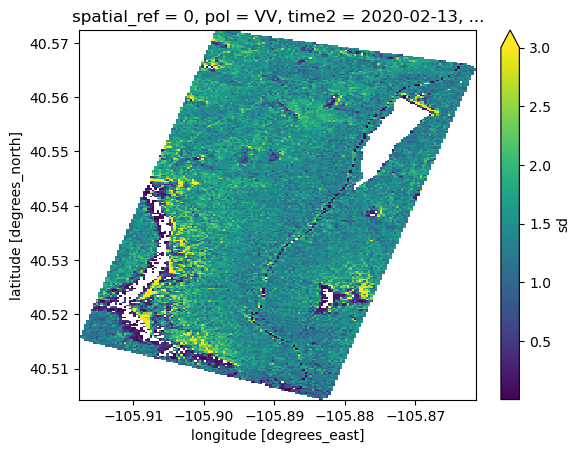

In [62]:
c = ds['cor'].isel(time1 = 0, time2 = 0, heading = 0)
sd = ds['sd'].mean('time').where(~c.sel(pol = 'VV').isnull())
sd.dropna('x', how = 'all').dropna('y', how = 'all').plot(vmax = 3)

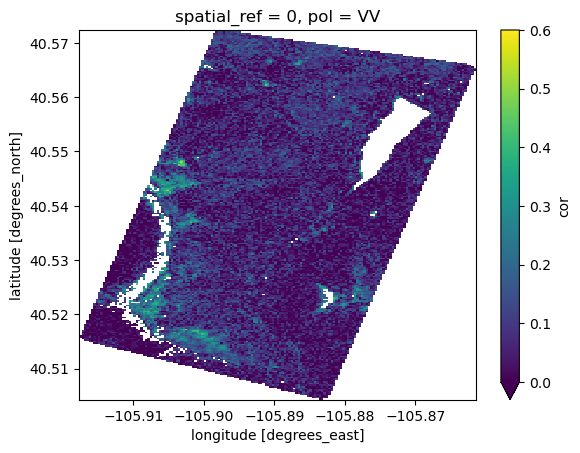

In [85]:
c = ds['cor'].isel(time1 = 7, time2 = 7, heading = 1)
((c.sel(pol = 'VV') - c.sel(pol = 'VH'))).where(~sd.isnull()).dropna('x', how = 'all').dropna('y', how = 'all').plot(vmax = 0.6, vmin = 0) #.where(~sd.isnull()).dropna('x', how = 'all').dropna('y', how = 'all')

In [ ]:
for stem, ds in dss.items():
    

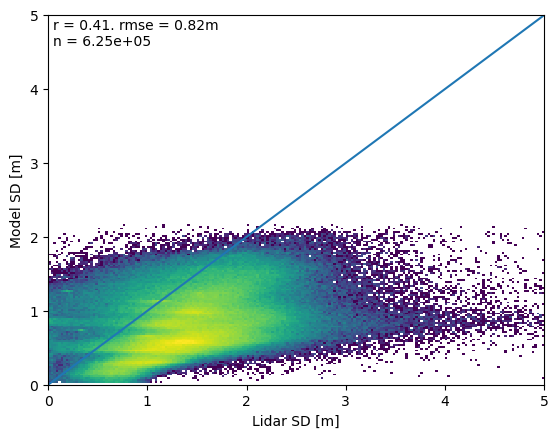

In [4]:
lidar = []
model = []
for stem, ds in dss.items():
    if 'sd' not in ds.data_vars: continue
    sub_fig_dir = fig_dir.joinpath('lidar_model_sd')
    sub_fig_dir.mkdir(exist_ok = True)
    for time in ds['sd'].time.values:
        fig, axes= plt.subplots(2, 1, figsize = (12, 8))
        ds['model_sd'].sel(model_time = time).where(~ds['sd'].sel(time = time).isnull()).dropna('x', how = 'all').dropna('y', how = 'all').plot(ax = axes[0], vmin = 0, vmax = 2, cbar_kwargs = {'label':''})
        ds['sd'].sel(time = time).dropna('x', how = 'all').dropna('y', how = 'all').plot(ax = axes[1], vmin = 0, vmax = 2, cbar_kwargs = {'label':''})
        
        model.extend(ds['model_sd'].sel(model_time = time).where(~ds['sd'].sel(time = time).isnull()).dropna('x', how = 'all').dropna('y', how = 'all').values.ravel())
        lidar.extend(ds['sd'].sel(time = time).dropna('x', how = 'all').dropna('y', how = 'all').values.ravel())
        
        axes[0].set_title('Model Snow Depth')
        axes[1].set_title('Lidar Snow Depth')
        plt.tight_layout()
        plt.savefig(sub_fig_dir.joinpath(f'{stem}_{pd.to_datetime(time).date()}' ))
        plt.close()
plt.hist2d(lidar, model, bins = 200, range=[[0,5],[0,5]], norm=mpl.colors.LogNorm())
plt.plot([0, 5], [0,5])
plt.xlabel('Lidar SD [m]')
plt.ylabel('Model SD [m]')
rmse, r, n = get_stats(lidar, model)
plt.text(0.01, 0.99, f'r = {r:.2f}. rmse = {rmse:.2f}m\nn = {n:.2e}', transform = plt.gca().transAxes, ha = 'left', va = 'top')
plt.savefig(sub_fig_dir.joinpath('overall_sd_lidar_compare.png'))

In [5]:
ds

<xarray.Dataset>
Dimensions:      (pol: 4, time2: 11, time1: 11, heading: 2, y: 1545, x: 1582,
                  time: 2, model_time: 363)
Coordinates:
  * pol          (pol) object 'HH' 'HV' 'VH' 'VV'
  * time2        (time2) datetime64[ns] 2020-02-20 2020-02-27 ... 2021-03-23
  * x            (x) float64 -106.0 -106.0 -106.0 ... -105.5 -105.5 -105.5
  * y            (y) float64 40.17 40.17 40.16 40.16 ... 39.74 39.74 39.74 39.74
  * time1        (time1) datetime64[ns] 2020-02-13 2020-02-20 ... 2021-03-17
  * heading      (heading) int64 52 233
    spatial_ref  int64 ...
  * time         (time) datetime64[ns] 2021-03-19 2020-02-11
  * model_time   (model_time) datetime64[ns] 2019-11-01 ... 2021-04-30
Data variables:
    cor          (pol, time2, time1, heading, y, x) float32 ...
    inc          (heading, y, x) float32 ...
    dem          (y, x) float32 ...
    vh           (y, x) float32 ...
    sd           (time, y, x) float32 ...
    tree_perc    (y, x) float32 ...
    land_cover   (y, x) int64 ...
    model_sd     (model_time, y, x) float32 ...
    model_melt   (model_time, y, x) float32 ...
    model_swe    (model_time, y, x) float32 ...

In [6]:
var_fig_dir = fig_dir.joinpath('cor_model')
var_fig_dir.mkdir(exist_ok = True)

cors = np.array([])
dswes = np.array([])
cummelts = np.array([])
swes = np.array([])


for stem, ds in dss.items():
    if 'VV' not in ds.pol: continue
    ts = find_cor_ts(ds)
    name = loc_colors[stem]['name']
    sub_fig_dir = var_fig_dir.joinpath(stem)
    sub_fig_dir.mkdir(exist_ok = True)

    ds = ds.where((ds['tree_perc'] < 10) & (ds["inc"] < np.deg2rad(60)))
    
    for heading, t1, t2 in ts:
        t1, t2 = pd.to_datetime(t1), pd.to_datetime(t2)
        if (t2 - t1).days > 13: continue
        cor = ds['cor'].sel(time1 = t1, time2 = t2, heading = heading, pol = 'VV')
        model = ds[['model_sd', 'model_melt', 'model_swe']].sel(model_time = slice(t1, t2))

        cor = cor.where((~model['model_sd'].isel(model_time = 0).isnull())).dropna('x', how = 'all').dropna('y', how = 'all')
        model = model.where((~cor.isnull())).dropna('x', how = 'all').dropna('y', how = 'all')

        # d_sd = model['model_sd'].isel(model_time = -1) - ds['model_sd'].isel(model_time = 0)
        d_swe = model['model_swe'].isel(model_time = -1) - ds['model_swe'].isel(model_time = 0)
        cum_melt = model['model_melt'].sum('model_time')
        swe = model['model_swe'].isel(model_time = -1)

        idx = (~np.isnan(cor.values.ravel())) & (~np.isnan(d_swe.values.ravel())) & (~np.isnan(cum_melt.values.ravel())) & (cum_melt.values.ravel() > 0) & (~np.isnan(swe.values.ravel()))
        ncor, d_swe, cum_melt, swe = cor.values.ravel()[idx], d_swe.values.ravel()[idx], cum_melt.values.ravel()[idx], swe.values.ravel()[idx]
        cors = np.concatenate([cors, ncor])
        dswes = np.concatenate([dswes, d_swe])
        cummelts = np.concatenate([cummelts, cum_melt])
        swes = np.concatenate([swes, swe])



        if sub_fig_dir.joinpath(f'{name}_{t1.date()}_{t2.date()}.png').exists(): continue

        fig, axes = plt.subplots(2, 2, figsize = (12, 8))
        axer = axes.ravel()
        cor.plot(ax = axer[0], cmap = 'Greys_r', cbar_kwargs = {'label': ''})
        model['model_swe'].isel(model_time = -1).plot(ax = axer[1], cmap = 'Blues', cbar_kwargs = {'label': ''}, vmin = 0, vmax = 1)
        d_swe.plot(ax = axer[2], cmap = 'RdBu', cbar_kwargs = {'label': ''}, vmin = -0.7, vmax = 0.7)
        cum_melt.plot(ax = axer[3], cmap = 'Reds', cbar_kwargs = {'label': ''}, vmin = 0, vmax = 0.2)
        map_grid_clean(axes)
        for ax, title in zip(axer, ['Coherence []', 'SWE [m]', 'dSWE [m]', 'Cumulative Melt [m]']): ax.set_title(title)
        fig.suptitle(f'{name} - {t1.date()} to {t2.date()}')
        plt.savefig(sub_fig_dir.joinpath(f'{name}_{t1.date()}_{t2.date()}.png'))
        plt.close()

: 

In [ ]:
cor.plot()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

Text(0.99, 0.99, 'r = -0.34. n = 5.83e+06')

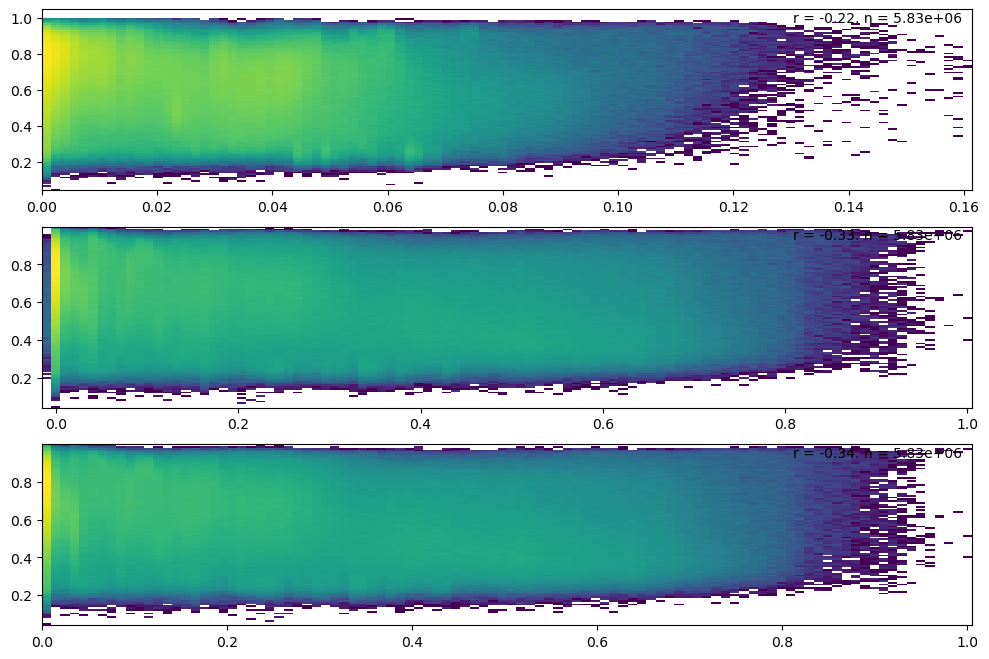

In [ ]:
fig, axes = plt.subplots(3, 1, figsize = (12, 8))

axes[0].hist2d(cummelts, cors, bins = 100, norm = mpl.colors.LogNorm())
_, r, n = get_stats(cummelts, cors)
axes[0].text(0.99, 0.99, f'r = {r:.2f}. n = {n:.2e}', va = 'top', ha = 'right', transform = axes[0].transAxes)
axes[0].set_ylim(top = 1.05)

axes[1].hist2d(dswes, cors, bins = 100, norm = mpl.colors.LogNorm())
_, r, n = get_stats(dswes, cors)
axes[1].text(0.99, 0.99, f'r = {r:.2f}. n = {n:.2e}', va = 'top', ha = 'right', transform = axes[1].transAxes)
axes[1].set_ylim(top = 1.05)

axes[2].hist2d(swes, cors, bins = 100, norm = mpl.colors.LogNorm())
_, r, n = get_stats(swes, cors)
axes[2].text(0.99, 0.99, f'r = {r:.2f}. n = {n:.2e}', va = 'top', ha = 'right', transform = axes[2].transAxes)
axes[2].set_ylim(top = 1.05)